In [1]:
# 生成器模型定义
# 导入所需要的包，请保证torchvision已经在你的环境中安装好.
# 在Windows需要单独安装torchvision包，在命令行运行pip install torchvision即可
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutil

import matplotlib.pyplot as plt
import numpy as np
image_size = 28  # 图像尺寸大小
input_dim = 100  # 输入给生成器的向量维度，维度越大可以增加生成器输出样本的多样性
num_channels = 1  # 图像的通道数
num_features = 64  # 生成器中间的卷积核数量
batch_size = 1  # 批次大小
# 如果系统中存在着GPU，我们将用GPU来完成张量的计算

use_cuda = torch.cuda.is_available()  # 定义一个布尔型变量，标志当前的GPU是否可用

# 如果当前GPU可用，则将优先在GPU上进行张量计算
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor


class ModelG(nn.Module):
    def __init__(self):
        super(ModelG, self).__init__()
        self.model = nn.Sequential()  # model为一个内嵌的序列化的神经网络模型

        # 利用add_module增加一个反卷积层，输入为input_dim维，输出为2*num_features维，窗口大小为5，padding是0
        # 输入图像大小为1，输出图像大小为W'=(W-1)S-2P+K+P'=(1-1)*2-2*0+5+0=3, 5*5
        self.model.add_module('deconv1', nn.ConvTranspose2d(input_dim, num_features * 2, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm1', nn.BatchNorm2d(num_features * 2))
        # 增加非线性层
        self.model.add_module('relu1', nn.ReLU(True))
        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口5，padding=0
        # 输入图像大小为5，输出图像大小为W'=(W-1)S-2P+K+P'=(5-1)*2-2*0+5+0=13, 13*13
        self.model.add_module('deconv2', nn.ConvTranspose2d(num_features * 2, num_features, 5, 2, 0, bias=False))
        # 增加一个batchnorm层
        self.model.add_module('bnorm2', nn.BatchNorm2d(num_features))
        # 增加非线性层
        self.model.add_module('relu2', nn.ReLU(True))

        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口4，padding=0
        # 输入图像大小为13，输出图像大小为W'=(W-1)S-2P+K+P'=(13-1)*2-2*0+4+0=28, 28*28
        self.model.add_module('deconv3', nn.ConvTranspose2d(num_features, num_channels, 4, 2, 0, bias=False))
        # self.model.add_module('tanh',nn.Tanh())
        self.model.add_module('sigmoid', nn.Sigmoid())

    def forward(self, input):
        output = input

        # 遍历网络的所有层，一层层输出信息
        for name, module in self.model.named_children():
            output = module(output)
        # 输出一张28*28的图像
        return (output)


def weight_init(m):
    # 模型参数初始化．
    # 默认的初始化参数卷积核的权重是均值大概为0，方差在10^{-2}. BatchNorm层的权重均值是大约0.5，方差在0.2左右
    # 使用如下初始化方式可以，可以让方差更小，使得收敛更快
    class_name = m.__class__.__name__
    if class_name.find('conv') != -1:
        m.weight.data.normal_(0, 0.02)
    if class_name.find('norm') != -1:
        m.weight.data.normal_(1.0, 0.02)


def make_show(img):
    # 将张量变成可以显示的图像
    img = img.data.expand(64, 3, 28, 28)
    return img


def imshow(inp, title=None, ax=None):
    # 在屏幕上绘制图像
    """Imshow for Tensor."""
    if inp.size()[0] > 1:
        inp = inp.numpy().transpose((1, 2, 0))
    else:
        inp = inp[0].numpy()
    mvalue = np.amin(inp)
    maxvalue = np.amax(inp)
    if maxvalue > mvalue:
        inp = (inp - mvalue) / (maxvalue - mvalue)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)


def picture_out(input_num):
    input_dim = 100  # 输入给生成器的向量维度，维度越大可以增加生成器输出样本的多样性
    input_num = float(input_num)
    fixed_noise = torch.FloatTensor([input_num]).resize_(1, 100, 1, 1).clone().normal_(0, 1)
    netG = ModelG()
    netG.load_state_dict(torch.load('E:\学习文件\pytorch\对抗神经网络——GAN\\CGAN\\net\\netG_epoch_99.pth'))
    netG.eval()
    fake_u = netG(fixed_noise)  # fixed_noise  这个是训练了100次的模型（导入了第一百次的参数）
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)
    # img = fake_u #.expand(sample_size, 3, image_size, image_size) #将张量转化成可绘制的图像
    # print(img.size())
    plt.axis('off')
    imshow(img[0], input_num, plt.gca())
    vutil.save_image(img, 'picture_out.png')
    Open_Img()


# 创建打开图像和显示图像函数
def Open_Img():
    global img_png
    Img = Image.open('picture_out.png')
    img_png = ImageTk.PhotoImage(Img)
    Show_Img()


def Show_Img():
    global img_png
    label_Img = tk.Label(root, image=img_png)
    label_Img.place(relx=0.3, rely=0.4, relwidth=0.3, relheight=0.1)
    label_Img.pack()

D:\Anaconda\envs\test\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


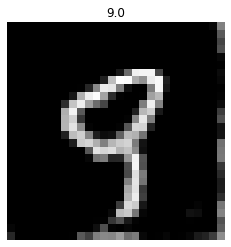

In [8]:
from PIL import Image, ImageTk # 导入图像处理函数库
import tkinter as tk
global img_png           # 定义全局变量 图像的
root = tk.Tk()
root.title('图像显示界面')
root.geometry('600x500')
inp1 = tk.Entry(root)
inp1.place(relx=0.1, rely=0.2, relwidth=0.3, relheight=0.1)
# 方法-直接调用 run1()
btn1 = tk.Button(root, text='生成手写数字图像', command=lambda: picture_out(inp1.get()))
btn1.place(relx=0.1, rely=0.4, relwidth=0.3, relheight=0.1)

root.mainloop()